### XGBoosting

https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/xgboost_pdp_ice.ipynb?flush_cache=trueXGBoosting


In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
#import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(42)                # set random seed for reproducibility

#### Import data and clean

In [2]:
# import XLS file
#path = "C:/Users/heine/Desktop/credit_cards_dataset.csv"
path = ".\\Data_USD.csv"
#data = pd.read_csv(path, skiprows=1) # skip the first row of the spreadsheet
data = pd.read_csv(path)
#path = 'C:\\Users\\User\\Desktop\\data\\original_data.csv'\
# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

In [3]:
data.shape

(30000, 11)

In [4]:
data['ID']=np.nan

In [5]:
data.shape

(30000, 12)

In [6]:
for i in range(0,30000):
    data.loc[i,['ID']]=i

In [7]:
data.columns

Index(['LIMIT_BAL_US', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_SCORE_AVG',
       'BILL_AVG_US', 'PAY_AMT_AVG_US', 'PAY_TO_BILL', 'CREDIT_UTILIZATION',
       'DEFAULT_PAYMENT_NEXT_MO', 'ID'],
      dtype='object')

In [8]:
data

,LIMIT_BAL_US,SEX,EDUCATION,MARRIAGE,AGE,PAY_SCORE_AVG,BILL_AVG_US,PAY_AMT_AVG_US,PAY_TO_BILL,CREDIT_UTILIZATION,DEFAULT_PAYMENT_NEXT_MO,ID
0,725.714286,2,2,1,24,-0.33,46.590857,4.166810,0.09,0.195650,1,0.0
1,4354.285714,2,2,2,26,0.50,103.275190,30.238095,0.29,0.022350,1,1.0
2,3265.714286,2,2,2,34,0.00,614.758619,66.632667,0.11,0.324878,0,2.0
3,1814.285714,2,2,1,37,0.00,1399.019905,50.727429,0.04,0.939800,0,3.0
4,1814.285714,1,2,1,57,-0.33,661.240619,357.105857,0.54,0.172340,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,7982.857143,1,3,1,39,0.00,4386.634429,257.326190,0.06,0.858855,0,29995.0
29996,5442.857143,1,3,2,43,-0.67,128.100667,87.630000,0.68,0.011220,0,29996.0
29997,1088.571429,1,2,2,37,1.33,426.332952,189.290476,0.44,0.118833,1,29997.0
29998,2902.857143,1,3,1,41,-0.17,1612.361762,890.094619,0.55,-0.020563,1,29998.0


In [9]:
data.ID = np.array('index0')

In [10]:
data.columns

Index(['LIMIT_BAL_US', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_SCORE_AVG',
       'BILL_AVG_US', 'PAY_AMT_AVG_US', 'PAY_TO_BILL', 'CREDIT_UTILIZATION',
       'DEFAULT_PAYMENT_NEXT_MO', 'ID'],
      dtype='object')

In [11]:
# assign target and inputs for GBM
#y = 'DEFAULT_NEXT_MONTH'
#y='default.payment.next.month'
y='DEFAULT_PAYMENT_NEXT_MO'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_PAYMENT_NEXT_MO
X = ['LIMIT_BAL_US', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_SCORE_AVG', 'BILL_AVG_US', 'PAY_AMT_AVG_US', 'PAY_TO_BILL', 'CREDIT_UTILIZATION']


In [12]:
y

'DEFAULT_PAYMENT_NEXT_MO'

In [13]:
X

['LIMIT_BAL_US',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_SCORE_AVG',
 'BILL_AVG_US',
 'PAY_AMT_AVG_US',
 'PAY_TO_BILL',
 'CREDIT_UTILIZATION']

In [14]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL_US,SEX,EDUCATION,MARRIAGE,AGE,PAY_SCORE_AVG,BILL_AVG_US,PAY_AMT_AVG_US,PAY_TO_BILL,CREDIT_UTILIZATION,DEFAULT_PAYMENT_NEXT_MO
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,6077.288279,1.603733,1.853133,1.551867,35.485500,-0.182680,1632.020583,191.415565,0.409982,0.423771,0.221200
std,4707.986577,0.489129,0.790349,0.521970,9.217904,0.982063,2295.460479,367.862624,7.671398,0.411462,0.415062
min,362.857143,1.000000,0.000000,0.000000,21.000000,-2.000000,-2033.566333,0.000000,-546.930000,-0.619892,0.000000
25%,1814.285714,1.000000,1.000000,1.000000,28.000000,-0.830000,173.494095,40.396583,0.040000,0.022032,0.000000
50%,5080.000000,2.000000,2.000000,2.000000,34.000000,0.000000,763.880810,86.982905,0.100000,0.313994,0.000000
75%,8708.571429,2.000000,2.000000,2.000000,41.000000,0.000000,2072.074548,202.616405,0.690000,0.829843,0.000000
max,36285.714290,2.000000,6.000000,3.000000,79.000000,6.000000,31833.959100,22763.637240,797.000000,6.455300,1.000000


In [15]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]

,DEFAULT_PAYMENT_NEXT_MO
LIMIT_BAL_US,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_SCORE_AVG,0.281957
BILL_AVG_US,-0.012691
PAY_AMT_AVG_US,-0.102354
PAY_TO_BILL,-0.010354
CREDIT_UTILIZATION,0.086168


In [16]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

In [17]:
np.random.seed(42) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21087, columns = 12
Test data rows = 8913, columns = 12


### Setting Parameter
https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [18]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 42                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress

[0]	train-auc:0.77134	eval-auc:0.75211
[1]	train-auc:0.77373	eval-auc:0.75352
[2]	train-auc:0.77497	eval-auc:0.75586
[3]	train-auc:0.77587	eval-auc:0.75723
[4]	train-auc:0.77639	eval-auc:0.75832
[5]	train-auc:0.77648	eval-auc:0.75849
[6]	train-auc:0.77660	eval-auc:0.75877
[7]	train-auc:0.77650	eval-auc:0.75876
[8]	train-auc:0.77685	eval-auc:0.75901
[9]	train-auc:0.77714	eval-auc:0.75920
[10]	train-auc:0.77750	eval-auc:0.75911
[11]	train-auc:0.77785	eval-auc:0.75914
[12]	train-auc:0.77811	eval-auc:0.75933
[13]	train-auc:0.77824	eval-auc:0.75941
[14]	train-auc:0.77832	eval-auc:0.75936
[15]	train-auc:0.77836	eval-auc:0.75928
[16]	train-auc:0.77844	eval-auc:0.75947
[17]	train-auc:0.77859	eval-auc:0.75959
[18]	train-auc:0.77879	eval-auc:0.75956
[19]	train-auc:0.77891	eval-auc:0.75959
[20]	train-auc:0.77899	eval-auc:0.75965
[21]	train-auc:0.77908	eval-auc:0.75965
[22]	train-auc:0.77913	eval-auc:0.75975
[23]	train-auc:0.77927	eval-auc:0.75996
[24]	train-auc:0.77944	eval-auc:0.76011
[25]	train

In [19]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True, ntree_limit=xgb_model.best_ntree_limit)

In [20]:
ypred=xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)

In [21]:
ypred.reshape(-1,1)

array([[0.38469255],
       [0.09784198],
       [0.20734623],
       ...,
       [0.8309802 ],
       [0.11311062],
       [0.14227647]], dtype=float32)

In [22]:
predictions = np.array([round(value) for value in ypred])

In [23]:
predictions.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [24]:
ypred.reshape(-1,1)

array([[0.38469255],
       [0.09784198],
       [0.20734623],
       ...,
       [0.8309802 ],
       [0.11311062],
       [0.14227647]], dtype=float32)

In [25]:
#xgb_model.predict(dtest, pred_contribs=True, ntree_limit=xgb_model.best_ntree_limit)

In [26]:
shap_values.reshape(-1,1)

array([[ 0.02226611],
       [-0.03322573],
       [ 0.0067748 ],
       ...,
       [-0.02428811],
       [-0.10920918],
       [-1.2901794 ]], dtype=float32)

In [27]:
#test['DEFAULT_PAYMENT_NEXT_MO']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

accuracy = accuracy_score(test[y], predictions)
cm = confusion_matrix(test[y], predictions)
precision = precision_score(test[y], predictions)
recall = recall_score(test[y], predictions)

In [29]:
print(accuracy)
print(cm)
print(precision)
print(recall)

0.805228318186918
[[6561  344]
 [1392  616]]
0.6416666666666667
0.30677290836653387


In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[6561  344]
 [1392  616]]


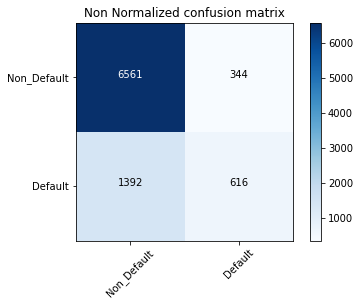

In [31]:
plt.figure()
plot_confusion_matrix(cm, classes=['Non_Default','Default'], normalize=False,
                      title='Non Normalized confusion matrix')
#plt.show()

In [32]:
y0=np.array(shap_values[:,10].reshape(-1,1))

In [33]:
y0

array([[-1.2901794],
       [-1.2901794],
       [-1.2901794],
       ...,
       [-1.2901794],
       [-1.2901794],
       [-1.2901794]], dtype=float32)

In [34]:
# plot Shapley variable importance summary 
#shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

### PDP

In [35]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe, ntree_limit=model.best_ntree_limit))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

In [36]:

par_dep_PAY_SCORE_AVG = par_dep('PAY_SCORE_AVG', test[X], xgb_model)         # calculate partial dependence for PAY_0
par_dep_BILL_AVG_US = par_dep('BILL_AVG_US', test[X], xgb_model) # calculate partial dependence for LIMIT_BAL
par_dep_CREDIT_UTILIZATION = par_dep('CREDIT_UTILIZATION', test[X], xgb_model) # calculate partial dependence for BILL_AMT1

# display partial dependence for LIMIT_BAL
par_dep_BILL_AVG_US

,BILL_AVG_US,partial_dependence
0,-1569.496238,0.353698
1,100.676529,0.261484
2,1770.849296,0.174243
3,3441.022063,0.171447
4,5111.194830,0.170485
5,6781.367597,0.170313
6,8451.540363,0.170124
7,10121.713130,0.170013
8,11791.885897,0.170006
9,13462.058664,0.169966


In [37]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [38]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 'index0',
 99: 'index0',
 10: 'index0',
 20: 'index0',
 30: 'index0',
 40: 'index0',
 50: 'index0',
 60: 'index0',
 70: 'index0',
 80: 'index0',
 90: 'index0'}

### ICE

In [39]:
# retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']
    
    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test[test['ID'] == int(percentile_dict[i])][X], 
                                          xgb_model, 
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    


    # ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1', 
                                          test[test['ID'] == int(percentile_dict[i])][X],  
                                          xgb_model, 
                                          bins=bins_BILL_AMT1)['partial_dependence']

NameError: name 'par_dep_PAY_0' is not defined

In [ ]:
par_dep_LIMIT_BAL_US

### Plotting partial dependence and ICE to validate and explain monotonic behavior

In [ ]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

In [ ]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

In [ ]:
_ = train['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: LIMIT_BAL')

In [ ]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) # plot partial dependence and ICE for PAY_0

In [ ]:
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0')

In [ ]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) # plot partial dependence and ICE for BILL_AMT1

In [ ]:
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: BILL_AMT1')

### Generate reason codes using the Shapley method

In [ ]:
test.reset_index(drop=True, inplace=True)

In [ ]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

In [ ]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

In [ ]:
s_df

In [ ]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

In [ ]:
row # helps understand reason codes